In [1]:
from pyspark.sql import SparkSession

In [2]:
import os
import urllib.request
import zipfile

In [3]:
spark = SparkSession.builder.appName("MovieLensAnalysis").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/25 10:41:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
dataset_url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
zip_path = "/tmp/ml-latest-small.zip"
extract_path = "/tmp/ml-latest-small/"

In [5]:
# Step 1: Download the dataset
if not os.path.exists(zip_path):
    print("Downloading MovieLens dataset...")
    urllib.request.urlretrieve(dataset_url, zip_path)
    print("Download complete!")

# Step 2: Extract the ZIP file
if not os.path.exists(extract_path):
    print("Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/tmp/")
    print("Extraction complete!")

Download complete!
Extracting dataset...
Extraction complete!


In [6]:
movies_path = os.path.join(extract_path, "movies.csv")
ratings_path = os.path.join(extract_path, "ratings.csv")
tags_path = os.path.join(extract_path, "tags.csv")
links_path = os.path.join(extract_path, "links.csv")

In [9]:
ratings_df = pd.read_csv('/tmp/ml-latest-small/ratings.csv')
movies_df = pd.read_csv('/tmp/ml-latest-small/movies.csv')

print("Ratings Data:")
print(ratings_df.head())

print("\nMovies Data:")
print(movies_df.head())

print("\nRatings Statistics:")
print(ratings_df.describe())

movie_ratings_count = ratings_df.groupby('movieId').size().reset_index(name='count')
print("\nMovie Ratings Count:")
print(movie_ratings_count.head())


Ratings Data:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Movies Data:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Ratings Statistics:
              userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+0

In [10]:
movies_df = spark.read.csv(f"file://{movies_path}", header=True, inferSchema=True)
ratings_df = spark.read.csv(f"file://{ratings_path}", header=True, inferSchema=True)
tags_df = spark.read.csv(f"file://{tags_path}", header=True, inferSchema=True)
links_df = spark.read.csv(f"file://{links_path}", header=True, inferSchema=True)


In [11]:
print("Movies DataFrame:")
movies_df.printSchema()
movies_df.show(5)

print("Ratings DataFrame:")
ratings_df.printSchema()
ratings_df.show(5)

print("Tags DataFrame:")
tags_df.printSchema()
tags_df.show(5)

print("Links DataFrame:")
links_df.printSchema()
links_df.show(5)

# Step 6: Display basic statistics
print("Movies count:", movies_df.count())
print("Ratings count:", ratings_df.count())
print("Tags count:", tags_df.count())
print("Links count:", links_df.count())

# Describe the ratings DataFrame
ratings_df.describe().show()

Movies DataFrame:
root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows

Ratings DataFrame:
root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      

24/11/25 10:42:53 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+----------------+------------------+--------------------+
|summary|            userId|         movieId|            rating|           timestamp|
+-------+------------------+----------------+------------------+--------------------+
|  count|            100836|          100836|            100836|              100836|
|   mean|326.12756356856676|19435.2957177992| 3.501556983616962|1.2059460873684695E9|
| stddev| 182.6184914635004|35530.9871987003|1.0425292390606342|2.1626103599513078E8|
|    min|                 1|               1|               0.5|           828124615|
|    max|               610|          193609|               5.0|          1537799250|
+-------+------------------+----------------+------------------+--------------------+



In [12]:
# movies_df.createOrReplaceTempView("movies_df")

# spark.sql("SELECT * FROM movies_df LIMIT 5").show()

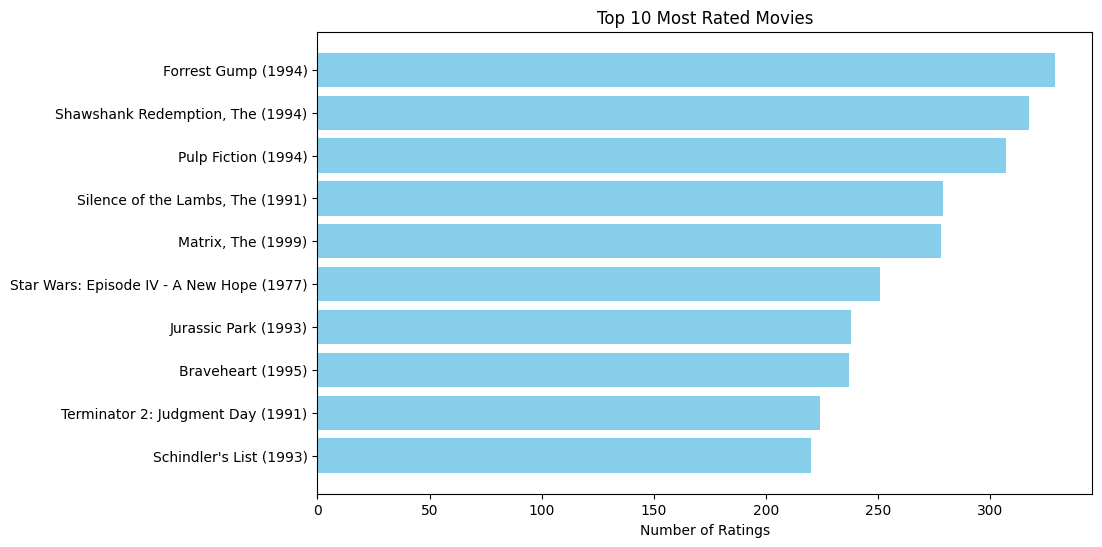

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Register the DataFrames as temporary views
movies_df.createOrReplaceTempView("movies_df")
ratings_df.createOrReplaceTempView("ratings_df")

# 1. Top 10 Most Rated Movies
top_rated_movies = spark.sql("""
    SELECT movies_df.title, COUNT(ratings_df.rating) as rating_count
    FROM ratings_df
    JOIN movies_df ON ratings_df.movieId = movies_df.movieId
    GROUP BY movies_df.title
    ORDER BY rating_count DESC
    LIMIT 10
""")

# Convert to Pandas for plotting
top_rated_movies_pd = top_rated_movies.toPandas()

# Plotting Top 10 Most Rated Movies
plt.figure(figsize=(10, 6))
plt.barh(top_rated_movies_pd['title'], top_rated_movies_pd['rating_count'], color='skyblue')
plt.xlabel("Number of Ratings")
plt.title("Top 10 Most Rated Movies")
plt.gca().invert_yaxis()
plt.show()

In [14]:
from pyspark.sql.types import *
from pyspark.sql.functions import col, mean, udf, lit, current_timestamp, unix_timestamp, array_contains
extract_genres = udf(lambda x: x.split("|"), ArrayType(StringType()))
movies_df_clean = movies_df.select("movieId", "title", extract_genres("genres").alias("genres"))
#display(movies_df_clean)

movies_df_clean.createOrReplaceTempView("movies_df_clean")

display (spark.sql("SELECT * FROM movies_df_clean limit 5"))

DataFrame[movieId: int, title: string, genres: array<string>]

In [15]:
genres_result = list(set(movies_df_clean.select('genres').rdd.flatMap(tuple).flatMap(tuple).collect()))
genres_result

['Children',
 'Comedy',
 'Animation',
 'Fantasy',
 'Crime',
 'Documentary',
 'Western',
 'War',
 'Adventure',
 'Thriller',
 'IMAX',
 'Romance',
 'Musical',
 'Film-Noir',
 'Mystery',
 '(no genres listed)',
 'Horror',
 'Drama',
 'Action',
 'Sci-Fi']

In [16]:
ratings_df.createOrReplaceTempView("ratings_df")
spark.sql("SELECT * FROM ratings_df limit 5").show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+



In [17]:
movie_ratings=ratings_df.drop('timestamp')

In [18]:
from pyspark.sql.types import IntegerType, FloatType
movie_ratings = movie_ratings.withColumn("userId", movie_ratings["userId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("movieId", movie_ratings["movieId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("rating", movie_ratings["rating"].cast(FloatType()))

In [19]:
movie_ratings.createOrReplaceTempView("movie_ratings")
spark.sql("SELECT * FROM movie_ratings limit 10").show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
|     1|     70|   3.0|
|     1|    101|   5.0|
|     1|    110|   4.0|
|     1|    151|   5.0|
|     1|    157|   5.0|
+------+-------+------+



In [20]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

In [21]:
#Create test and train set
(training,test)=movie_ratings.randomSplit([0.8,0.2])

In [22]:
# Create ALS model
# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5, rank=10, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")

In [23]:
# 1st print a list of parameters
print(als.explainParams())

alpha: alpha for implicit preference (default: 1.0)
blockSize: block size for stacking input data in matrices. Data is stacked within partitions. If block size is more than remaining data in a partition then it is adjusted to the size of this data. (default: 4096)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
coldStartStrategy: strategy for dealing with unknown or new users/items at prediction time. This may be useful in cross-validation or production scenarios, for handling user/item ids the model has not seen in the training data. Supported values: 'nan', 'drop'. (default: nan, current: drop)
finalStorageLevel: StorageLevel for ALS model factors. (default: MEMORY_AND_DISK)
implicitPrefs: whether to use implicit preference (default: False)
intermediateStorageLevel: StorageLe

In [24]:
#Tune model using ParamGridBuilder
# it will take long time in the cv period, so just use few parameter to try 

paramGrid = (ParamGridBuilder()
             .addGrid(als.regParam, [0.01])
             .addGrid(als.rank, [10])
             .addGrid(als.maxIter, [15])
             .build())

In [25]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")

In [26]:
from pyspark.ml.tuning import CrossValidator
# Build Cross validation 
# Create 5-fold CrossValidator
# it takes too long that I only use 2-fold
cv = CrossValidator(estimator=als, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=2)

# Run cross validations
cvModel = cv.fit(training)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

In [27]:
# Extract the best model selected by CV
best_model = cvModel.bestModel

In [28]:
#Fit ALS model to training data

# specify parameter settings by the best model obtained via CV
print ("**Best Model**")
print ("Rank: ", best_model)
print (" MaxIter: ", str(best_model._java_obj.parent().getMaxIter()))
print (" RegParam:",  best_model._java_obj.parent().regParam())

**Best Model**
Rank:  ALSModel: uid=ALS_c17aa03851fc, rank=10
 MaxIter:  15
 RegParam: ALS_c17aa03851fc__regParam


In [29]:
#Generate predictions and evaluate using RMSE
predictions=best_model.transform(test)
rmse = evaluator.evaluate(predictions)

In [30]:
#Print RMSE 
print ("RMSE = "+str(rmse))

RMSE = 1.1304085932643928


In [31]:
#Extract best model from the tuning exercise using ParamGridBuilder

als_best = ALS(maxIter=15, rank=10, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
model = als_best.fit(training)

In [32]:
#predictions.show(10)

predictions.createOrReplaceTempView("predictions")

spark.sql("SELECT * FROM predictions limit 10").show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   148|    356|   4.0|  2.892863|
|   148|   4993|   3.0| 3.9620233|
|   148|   5618|   3.0| 2.9439938|
|   148|   5952|   3.0| 3.8388844|
|   148|   6377|   3.0|  2.986417|
|   148|  31658|   4.0| 2.1880844|
|   148|  40815|   4.0|  3.867415|
|   148|  50872|   3.0| 1.5943685|
|   148|  69757|   3.5| 3.5969737|
|   148|  79091|   3.5| 3.8074276|
+------+-------+------+----------+



In [33]:
alldata=best_model.transform(movie_ratings)
rmse = evaluator.evaluate(alldata)
print ("RMSE = "+str(rmse))

RMSE = 0.6467114891087848


In [34]:
alldata.registerTempTable("alldata")

/opt/conda/envs/csgy-6513-fall/lib/python3.11/site-packages/pyspark/sql/dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [35]:
#recommend 10 movies for each users
user_recs = best_model.recommendForAllUsers(10)
#user_recs.show(10)

user_recs.createOrReplaceTempView("user_recs")

spark.sql("SELECT * FROM user_recs limit 10").show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|     1|[{5666, 7.700826}...|
|     2|[{34338, 7.77922}...|
|     3|[{8957, 7.52417},...|
|     4|[{7748, 9.439089}...|
|     5|[{60397, 7.344929...|
|     6|[{60397, 6.786498...|
|     7|[{42723, 8.613301...|
|     8|[{971, 7.866883},...|
|     9|[{6932, 8.315705}...|
|    10|[{82202, 9.041143...|
+------+--------------------+



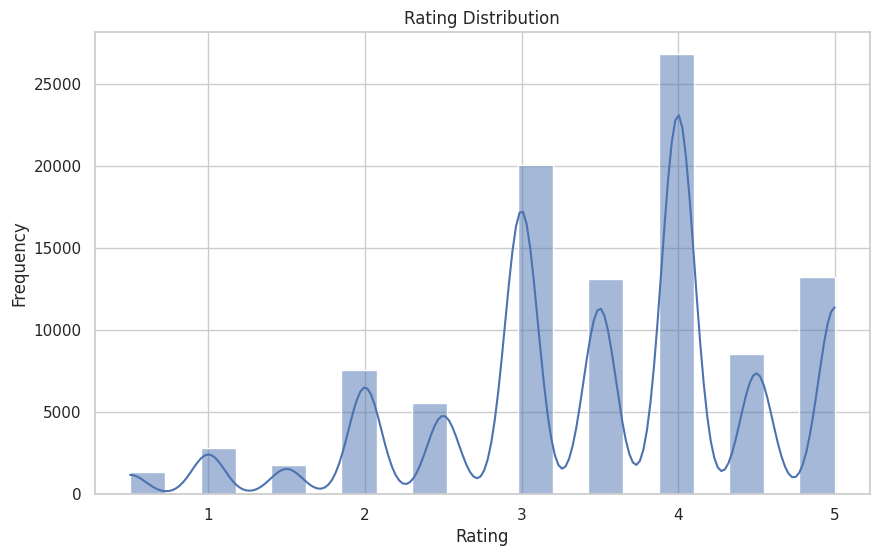

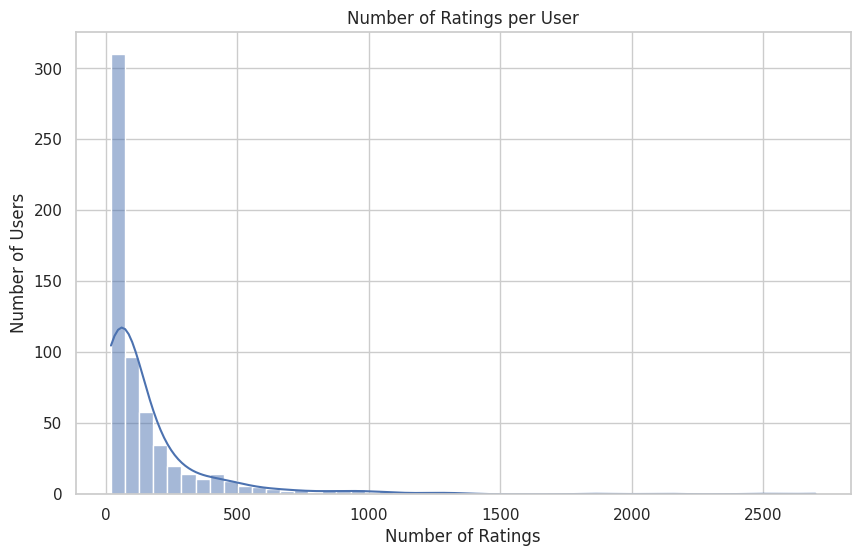

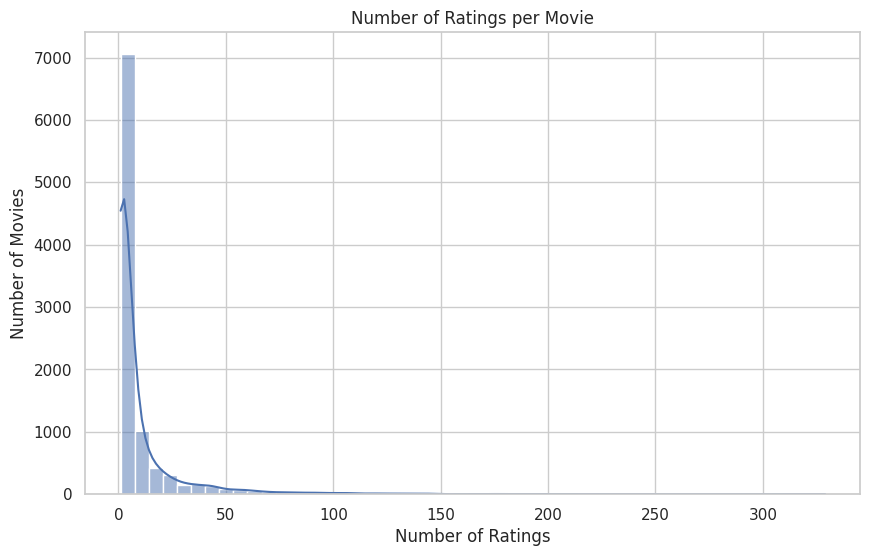

In [42]:
if isinstance(ratings_df, pd.DataFrame):
    ratings_data = ratings_df
else:
    ratings_data = ratings_df.toPandas()

sns.set(style='whitegrid')

plt.figure(figsize=(10, 6))
sns.histplot(data=ratings_data, x='rating', bins=20, kde=True)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


user_ratings_count = ratings_data.groupby('userId').size().reset_index(name='count')


plt.figure(figsize=(10, 6))
sns.histplot(data=user_ratings_count, x='count', bins=50, kde=True)
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()

movie_ratings_count = ratings_data.groupby('movieId').size().reset_index(name='count')

plt.figure(figsize=(10, 6))
sns.histplot(data=movie_ratings_count, x='count', bins=50, kde=True)
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.show()


In [ ]:
#与前面一个一致，但是als模型
""""
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
import seaborn as sns
import matplotlib.pyplot as plt

if isinstance(ratings_df, pd.DataFrame):
    ratings_data = ratings_df
else:
    ratings_data = ratings_df.toPandas()
sns.set(style='whitegrid')

plt.figure(figsize=(10, 6))
sns.histplot(data=ratings_data, x='rating', bins=20, kde=True)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


user_ratings_count = ratings_data.groupby('userId').size().reset_index(name='count')
plt.figure(figsize=(10, 6))
sns.histplot(data=user_ratings_count, x='count', bins=50, kde=True)
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()

movie_ratings_count = ratings_data.groupby('movieId').size().reset_index(name='count')
plt.figure(figsize=(10, 6))
sns.histplot(data=movie_ratings_count, x='count', bins=50, kde=True)
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.show()

spark = SparkSession.builder \
    .appName("MovieLensALS") \
    .getOrCreate()

ratings_spark_df = spark.createDataFrame(ratings_data)

(training, test) = ratings_spark_df.randomSplit([0.8, 0.2])


als = ALS(
    maxIter=10,
    regParam=0.1,
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    coldStartStrategy="drop"
)

model = als.fit(training)

predictions = model.transform(test)


evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)
rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error = {rmse}")
"""

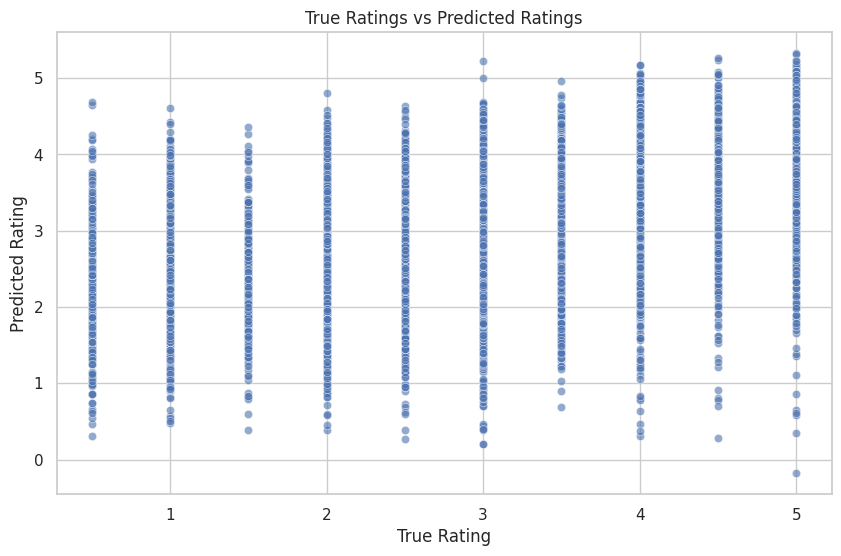

In [65]:
#movie re
predictions_df = predictions.toPandas()


plt.figure(figsize=(10, 6))
sns.scatterplot(x='rating', y='prediction', data=predictions_df, alpha=0.6)
plt.title('True Ratings vs Predicted Ratings')
plt.xlabel('True Rating')
plt.ylabel('Predicted Rating')
plt.show()



all_user_recommendations = model.recommendForAllUsers(10)
all_user_recommendations_df = all_user_recommendations.toPandas()




In [66]:
# Function to flatten the recommendations into a DataFrame
def flatten_recommendations(recommendations_df):
    recommendations_df = recommendations_df.explode("recommendations")  # Flatten the recommendations list
    recommendations_df["movie_id"] = recommendations_df["recommendations"].apply(lambda x: x[0])
    recommendations_df["predicted_rating"] = recommendations_df["recommendations"].apply(lambda x: x[1])
    recommendations_df = recommendations_df.drop(columns=["recommendations"])  # Drop the old recommendations column
    return recommendations_df

# Flatten recommendations for all users
all_user_recommendations_df = flatten_recommendations(all_user_recommendations_df)

# Print the results for all users
print("Recommended Movies for All Users:")
print(all_user_recommendations_df.head())

# Assuming `user_recommendations_df` has already been flattened, no need to flatten it again
print(f"\nRecommended Movies for User {user_id}:")
print(user_recommendations_df.head())


Recommended Movies for All Users:
   userId  movie_id  predicted_rating
0       1     33649          5.903435
0       1     26471          5.596930
0       1      3508          5.595965
0       1      7096          5.573612
0       1      3925          5.536465

Recommended Movies for User 1:
   userId  movie_id  predicted_rating
0       1     33649          5.903435
0       1     26471          5.596930
0       1      3508          5.595965
0       1      7096          5.573612
0       1      3925          5.536465
